In [1]:
import random
import time
from typing import Dict, Any
import torch
import torch.multiprocessing as mp
from tqdm import tqdm
import numpy as np
from gaussian_splatting.gaussian_renderer import render
from gaussian_splatting.utils.loss_utils import l1_loss, ssim
from gaussian_splatting.scene.gaussian_model import GaussianModel
from utils.logging_utils import Log
from utils.multiprocessing_utils import clone_obj
from utils.pose_utils import update_pose
from utils.slam_utils import get_loss_mapping
from utils.camera_utils import Camera
import cv2
import math
from dataclasses import dataclass

from utils.slam_utils import get_loss_tracking, get_median_depth, get_loss_tracking_rgb, get_loss_tracking_rgbd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def getProjectionMatrix2(znear, zfar, cx, cy, fx, fy, W, H):
    left = ((2 * cx - W) / W - 1.0) * W / 2.0
    right = ((2 * cx - W) / W + 1.0) * W / 2.0
    top = ((2 * cy - H) / H + 1.0) * H / 2.0
    bottom = ((2 * cy - H) / H - 1.0) * H / 2.0
    left = znear / fx * left
    right = znear / fx * right
    top = znear / fy * top
    bottom = znear / fy * bottom
    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)

    return P


def focal2fov(focal, pixels):
    return 2 * math.atan(pixels / (2 * focal))


In [3]:
def get_render_settings(
    w: int,
    h: int,
    intrinsics: np.ndarray,
    w2c: torch.Tensor,
    near = 0.01,
    far = 100,
    sh_degree = 0
) -> Dict[str, Any]:
    """
    Create render settings for Gaussian splatting rasterization.
    
    Args:
        w: Image width
        h: Image height
        intrinsics: 3x3 camera intrinsics matrix (numpy array or similar)
        w2c: 4x4 world-to-camera transformation tensor
        near: Near clipping plane
        far: Far clipping plane
        sh_degree: Spherical harmonics degree
        
    Returns:
        Dictionary containing raster settings
    """
    
    # Extract camera intrinsics
    fx = intrinsics[0, 0]
    fy = intrinsics[1, 1]
    cx = intrinsics[0, 2]
    cy = intrinsics[1, 2]

    # Convert w2c to tensor and move to GPU
    w2c_tensor = w2c.transpose(0, 1)
    
    # Compute camera center
    w2c_inv = torch.inverse(w2c_tensor)
    cam_center = w2c_inv[0:3, 3]
    
    # Get view matrix (transpose of w2c)
    viewmatrix = w2c_tensor.transpose(0, 1)
    
    # Create OpenGL projection matrix
    opengl_proj = torch.zeros(4, 4, dtype=torch.float32, device='cuda')
    
    opengl_proj[0, 0] = 2 * fx / w
    opengl_proj[0, 2] = -(w - 2 * cx) / w
    opengl_proj[1, 1] = 2 * fy / h
    opengl_proj[1, 2] = -(h - 2 * cy) / h
    opengl_proj[2, 2] = far / (far - near)
    opengl_proj[2, 3] = -(far * near) / (far - near)
    opengl_proj[3, 2] = 1.0
    
    opengl_proj = opengl_proj.transpose(0, 1)
    
    # Compute full projection matrix
    full_proj_matrix = torch.matmul(
        viewmatrix.unsqueeze(0),
        opengl_proj.unsqueeze(0)
    ).squeeze(0)
    
    # Create raster settings dictionary
    raster_settings = {
        'image_height': h,
        'image_width': w,
        'tanfovx': w / (2 * fx),
        'tanfovy': h / (2 * fy),
        'bg': torch.zeros(3, dtype=torch.float32, device='cuda'),
        'scale_modifier': 1.0,
        'viewmatrix': viewmatrix,
        'projmatrix': full_proj_matrix,
        'sh_degree': sh_degree,
        'campos': cam_center,
        'prefiltered': False,
        'debug': False
    }
    
    return raster_settings


@dataclass
class pipeline_params:
    convert_SHs_python =  False
    compute_cov3D_python =  False

pipline = pipeline_params 

In [1]:
def compute_loss(gaussian_model, color, depth, color_gt, depth_gt, mask, compute_depth_loss=True):
    """
    Compute loss for Gaussian Splatting optimization.
    
    Args:
        color: Rendered RGB image [3, H, W]
        depth: Rendered depth map [1, H, W]
        color_gt: Ground truth RGB image [3, H, W]
        depth_gt: Ground truth depth map [H, W] or [1, H, W]
        mask: Valid pixel mask [H, W]
        compute_depth_loss: Whether to include depth loss
    
    Returns:
        Total loss (scalar tensor)
    """
    # Compute L1 color loss with mask
    l1_color = torch.nn.functional.l1_loss(
        color * mask.unsqueeze(0), 
        color_gt * mask.unsqueeze(0)
    )
    
    # Compute isotropic loss (regularization on Gaussian scales)
    scales = gaussian_model.get_scaling
    isotropic_loss = torch.abs(scales - scales.mean(dim=1, keepdim=True)).mean()
    
    if compute_depth_loss:
        # Create depth mask: valid depth AND valid pixels
        if depth_gt.dim() == 2:
            depth_mask = (depth_gt > 0.0) & mask
        else:
            depth_mask = (depth_gt.squeeze(0) > 0.0) & mask
        
        # Compute L1 depth loss only on valid pixels
        depth_valid = depth.squeeze(0)[depth_mask]
        depth_gt_valid = depth_gt.squeeze(0)[depth_mask] if depth_gt.dim() == 3 else depth_gt[depth_mask]
        
        l1_depth = torch.nn.functional.l1_loss(depth_valid, depth_gt_valid)
        loss = l1_color + l1_depth + 10.0 * isotropic_loss
    else:
        loss = l1_color + 10.0 * isotropic_loss
    
    return loss

In [5]:
dataset_root = "../gs_obj_opt/data/NOCS/val/00337"
image_path = dataset_root + "/0008_color.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = img.astype(np.float32) / 255.0
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.permute(2, 0, 1).to(torch.device("cuda"))


depth_path = dataset_root + "/0008_depth.png";
depth_img_ = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED);
depth_channels = cv2.split(depth_img_)
# print(f"depth_channels[0]: {depth_channels[0].shape}")

# compute the depth values, 2nd channel * 256 + 3rd channel
depth_channel_1 = depth_channels[1].astype(np.float32)
depth_channel_2 = depth_channels[2].astype(np.float32)
depth_img = depth_channel_1 * 256 + depth_channel_2
depth_img = depth_img.astype(np.float32) / 1000.0
depth_tensor = torch.from_numpy(depth_img)
depth_tensor = depth_tensor.unsqueeze(0).to(torch.device("cuda"))

In [6]:
mask_path = dataset_root + "/0008_mask.png"
mask_all = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
instance_id = 1
channel = 2

# extract the channel
mask_channels = cv2.split(mask_all)
mask = (mask_channels[channel] == instance_id)

# visualize the mask
# cv2.imshow("mask", mask)
# cv2.waitKey(0)

# convert the mask image to torch.Tensor
mask_tensor = torch.from_numpy(mask)
mask_tensor = mask_tensor.to(torch.device("cuda"))
print(f"mask_tensor shape: {mask_tensor.shape}")

masked_color = img_tensor * mask_tensor.unsqueeze(0)

# visualize the masked color image
masked_color_ = masked_color.to(torch.device("cpu"))
masked_color_ = masked_color_.permute(1, 2, 0).contiguous()
masked_color_ = (masked_color_ * 255).clamp(0, 255).to(torch.uint8)
masked_color_img = masked_color_.numpy()
masked_color_img = cv2.cvtColor(masked_color_img, cv2.COLOR_RGB2BGR)
# cv2.imshow("masked color image", masked_color_img)
# cv2.waitKey(0)

cv2.imwrite("./Jacob_test_result/masked_color_img.png", masked_color_img)

# load w2c gt and T noise
pose_data_root = "./Jacob_test_result/"
w2c_gt_path = pose_data_root + "w2c_gt.txt"
T_noise_path = pose_data_root + "T_noise.txt"
w2c_gt = np.loadtxt(w2c_gt_path, dtype=np.float32)
T_noise = np.loadtxt(T_noise_path, dtype=np.float32)

print(f"w2c_gt: {w2c_gt}")
print(f"T_noise: {T_noise}")

cam_intrinsics = np.array([
    [577.5, 0, 319.5],
    [0, 577.5, 239.5],
    [0, 0, 1]
], dtype=np.float32)

fx = cam_intrinsics[0, 0]
fy = cam_intrinsics[1, 1]
cx = cam_intrinsics[0, 2]
cy = cam_intrinsics[1, 2]

w = 640
h = 480

w2c = w2c_gt @ T_noise
# use an identity matrix for testing
# w2c = np.eye(4, dtype=np.float32)
# w2c = w2c_gt
print(f"w2c: {w2c}")
w2c_ = torch.from_numpy(w2c).to(torch.device("cuda"))
w2c_ = w2c_.transpose(0,1) 
print("w2c_: \n", w2c_)

mask_tensor shape: torch.Size([480, 640])
w2c_gt: [[ 7.6530971e-02  4.5813790e-01  1.1761957e-03 -4.3262941e-01]
 [ 2.7590185e-01 -4.5136519e-02 -3.7093070e-01 -2.2215320e-01]
 [-3.6574566e-01  6.1814789e-02 -2.7956706e-01  1.2286607e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
T_noise: [[ 0.9848077  -0.17364818  0.          0.15      ]
 [ 0.17364818  0.9848077   0.          0.15      ]
 [ 0.          0.          1.          0.15      ]
 [ 0.          0.          0.          1.        ]]
w2c: [[ 0.15492311  0.4378883   0.0011762  -0.35225263]
 [ 0.2638724  -0.09236065 -0.3709307  -0.24317801]
 [-0.34945515  0.12438674 -0.27956706  1.141136  ]
 [ 0.          0.          0.          1.        ]]
w2c_: 
 tensor([[ 0.1549,  0.2639, -0.3495,  0.0000],
        [ 0.4379, -0.0924,  0.1244,  0.0000],
        [ 0.0012, -0.3709, -0.2796,  0.0000],
        [-0.3523, -0.2432,  1.1411,  1.0000]], device='cuda:0')


In [7]:
render_setting = get_render_settings(w, h, cam_intrinsics, w2c_)

In [8]:
render_setting

{'image_height': 480,
 'image_width': 640,
 'tanfovx': 0.5541125541125541,
 'tanfovy': 0.4155844155844156,
 'bg': tensor([0., 0., 0.], device='cuda:0'),
 'scale_modifier': 1.0,
 'viewmatrix': tensor([[ 0.1549,  0.2639, -0.3495,  0.0000],
         [ 0.4379, -0.0924,  0.1244,  0.0000],
         [ 0.0012, -0.3709, -0.2796,  0.0000],
         [-0.3523, -0.2432,  1.1411,  1.0000]], device='cuda:0'),
 'projmatrix': tensor([[ 0.2801,  0.6357, -0.3495, -0.3495],
         [ 0.7901, -0.2225,  0.1244,  0.1244],
         [ 0.0026, -0.8920, -0.2796, -0.2796],
         [-0.6375, -0.5875,  1.1312,  1.1411]], device='cuda:0'),
 'sh_degree': 0,
 'campos': tensor([ 2.3987, -0.0471,  1.0625], device='cuda:0'),
 'prefiltered': False,
 'debug': False}

In [9]:
fovx = focal2fov(fx, w)
fovy = focal2fov(fy, h)

viewpoint = Camera(0, img_tensor, depth_tensor, w2c_gt, render_setting['projmatrix'], fx, fy, cx, cy, fovx, fovy, h, w, render_setting['viewmatrix'].T)

gaussian_model = GaussianModel(0)
gaussian_model.load_tensors("./optimized_params.pt")

Parameter: 0, shape: torch.Size([29707, 3])
Parameter: 1, shape: torch.Size([29707, 1, 3])
Parameter: 2, shape: torch.Size([29707, 15, 3])
Parameter: 3, shape: torch.Size([29707, 1])
Parameter: 4, shape: torch.Size([29707, 3])
Parameter: 5, shape: torch.Size([29707, 4])
Successfully loaded 29707 Gaussians from ./optimized_params.pt


True

In [11]:
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

render_pkg = render(
                viewpoint, gaussian_model, pipline, background
            )
render_image, render_depth, render_opacity = (
    render_pkg["render"],
    render_pkg["depth"],
    render_pkg["opacity"],
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0094296].


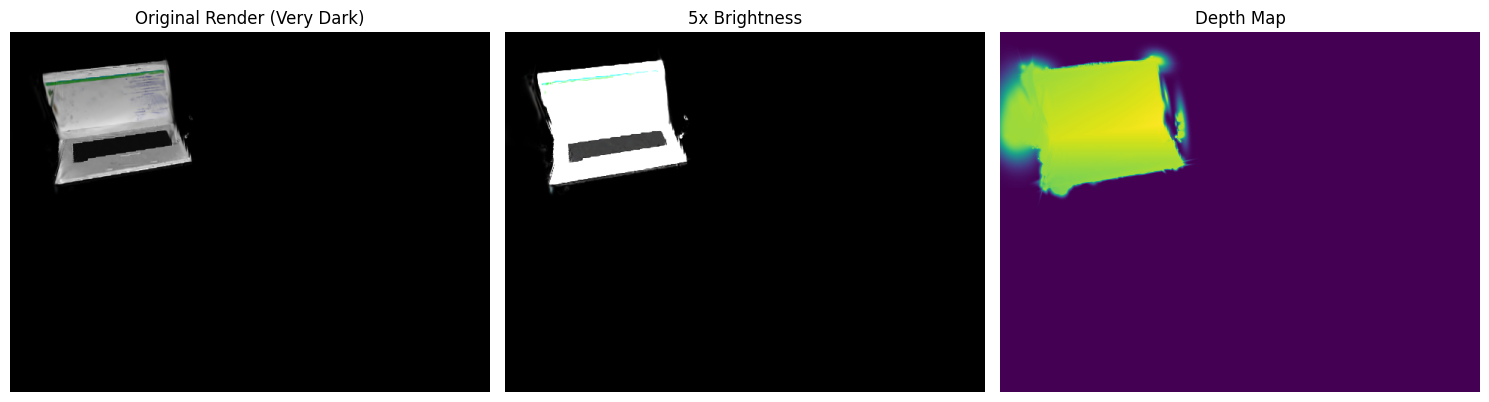


Image statistics:
  Non-zero pixels: 96192 / 921600
  Pixels > 0.1: 63879
  Pixels > 0.5: 56164

Saved corrected image to: ./Jacob_test_result/rendered_img_corrected.png


In [12]:
# Let's visualize the image properly with contrast enhancement
import matplotlib.pyplot as plt

col_img = viewpoint.original_image.permute(1, 2, 0).cpu().detach().numpy()
col_img = (col_img * 255).clip(0, 255).astype('uint8')
col_img = cv2.cvtColor(col_img, cv2.COLOR_RGB2BGR)

cv2.imwrite("./Jacob_test_result/viewpoint_orig_image.png", col_img)

# Show original (very dark)
img_display = render_image.permute(1, 2, 0).cpu().detach().numpy()
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CORRECT way to save with cv2.imwrite:
# 1. Convert from float [0,1] to uint8 [0,255]
# 2. Convert from RGB to BGR
img_to_save = (img_display * 255).clip(0, 255).astype('uint8')
img_to_save_bgr = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)
cv2.imwrite("./Jacob_test_result/rendered_noisy_img.png", img_to_save_bgr)

axes[0].imshow(img_display)
axes[0].set_title('Original Render (Very Dark)')
axes[0].axis('off')

# Show with contrast enhancement
img_enhanced = np.clip(img_display * 5, 0, 1)  # 5x brightness
axes[1].imshow(img_enhanced)
axes[1].set_title('5x Brightness')
axes[1].axis('off')

# Show depth map
depth_display = render_depth.squeeze().cpu().detach().numpy()
axes[2].imshow(depth_display, cmap='viridis')
axes[2].set_title('Depth Map')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('./Jacob_test_result/debug_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nImage statistics:")
print(f"  Non-zero pixels: {(img_display > 0).sum()} / {img_display.size}")
print(f"  Pixels > 0.1: {(img_display > 0.1).sum()}")
print(f"  Pixels > 0.5: {(img_display > 0.5).sum()}")
print(f"\nSaved corrected image to: ./Jacob_test_result/rendered_img_corrected.png")

In [13]:
loss = compute_loss(gaussian_model, render_image, render_depth, viewpoint.original_image, viewpoint.depth, mask_tensor, compute_depth_loss=True)

print("loss: ", loss)

loss:  tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)


In [14]:
loss.backward()
# pose_optimizers.step()

 grad_tau (dL_dtau) :   tensor([ 0.1546,  0.3316, -0.9618, -0.1568, -0.2514, -0.0860], device='cuda:0')


## Code for iterative optimization
Need to decide on the Learning rates

In [13]:
loss_plot = []

In [10]:
# Setup the optimizer params:

# LR: 0.000034, LR_trans: 0.000014

opt_params=[]
opt_params.append(
        {
            "params": [viewpoint.cam_rot_delta],
            "lr": 0.0005,  # Much more conservative
            "name": "rot_{}".format(viewpoint.uid),
        }
    )
opt_params.append(
    {
        "params": [viewpoint.cam_trans_delta],
        "lr": 0.0002,  # Much more conservative
        "name": "trans_{}".format(viewpoint.uid),
    }
)
opt_params.append(
{
    "params": [viewpoint.exposure_a],
    "lr": 0.001,
    "name": "exposure_a_{}".format(viewpoint.uid),
}
)
opt_params.append(
{
    "params": [viewpoint.exposure_b],
    "lr": 0.001,
    "name": "exposure_b_{}".format(viewpoint.uid),
}
)
pose_optimizers = torch.optim.Adam(opt_params)

# Add step-based learning rate scheduler with slower decay
scheduler = torch.optim.lr_scheduler.StepLR(pose_optimizers, step_size=50, gamma=0.8)

In [15]:
converged = False
i = 0

while i < 5000:
    pose_optimizers.zero_grad()  # Zero gradients before each iteration

    render_pkg = render(
                viewpoint, gaussian_model, pipline, background
            )
    render_image, render_depth, render_opacity = (
        render_pkg["render"],
        render_pkg["depth"],
        render_pkg["opacity"],
    )

    loss = compute_loss(gaussian_model, render_image, render_depth, viewpoint.original_image, viewpoint.depth, mask_tensor, compute_depth_loss=True)
    if i % 10 == 0:  # Print every 10 iterations to reduce output
        print(f"Iteration {i}, Loss: {loss.item():.6f}, LR: {pose_optimizers.param_groups[0]['lr']:.6f}, LR_trans: {pose_optimizers.param_groups[1]['lr']:.6f}")
    loss_plot.append(loss.item())
    loss.backward()
    pose_optimizers.step()
    scheduler.step()  # Decay learning rate
    # print(" cam_rot_delta", viewpoint.cam_rot_delta)
    # print(" cam_trans_delta", viewpoint.cam_trans_delta)
    converged = update_pose(viewpoint)
    i =  i + 1

Iteration 0, Loss: 0.108947, LR: 0.000500, LR_trans: 0.000200
Iteration 10, Loss: 0.108967, LR: 0.000500, LR_trans: 0.000200
Iteration 20, Loss: 0.108988, LR: 0.000500, LR_trans: 0.000200
Iteration 30, Loss: 0.109007, LR: 0.000500, LR_trans: 0.000200
Iteration 40, Loss: 0.109025, LR: 0.000500, LR_trans: 0.000200
Iteration 50, Loss: 0.109046, LR: 0.000400, LR_trans: 0.000160
Iteration 60, Loss: 0.109059, LR: 0.000400, LR_trans: 0.000160
Iteration 70, Loss: 0.109072, LR: 0.000400, LR_trans: 0.000160
Iteration 80, Loss: 0.109088, LR: 0.000400, LR_trans: 0.000160
Iteration 90, Loss: 0.109113, LR: 0.000400, LR_trans: 0.000160
Iteration 100, Loss: 0.109130, LR: 0.000320, LR_trans: 0.000128
Iteration 110, Loss: 0.109158, LR: 0.000320, LR_trans: 0.000128
Iteration 120, Loss: 0.109172, LR: 0.000320, LR_trans: 0.000128
Iteration 130, Loss: 0.109185, LR: 0.000320, LR_trans: 0.000128
Iteration 140, Loss: 0.109196, LR: 0.000320, LR_trans: 0.000128
Iteration 150, Loss: 0.109213, LR: 0.000256, LR_tra

In [155]:
render_pkg = render(
                viewpoint, gaussian_model, pipline, background
            )
render_image, render_depth, render_opacity = (
    render_pkg["render"],
    render_pkg["depth"],
    render_pkg["opacity"],
)

img_display = render_image.permute(1, 2, 0).cpu().detach().numpy()

# CORRECT way to save with cv2.imwrite:
# 1. Convert from float [0,1] to uint8 [0,255]
# 2. Convert from RGB to BGR
img_to_save = (img_display * 255).clip(0, 255).astype('uint8')
img_to_save_bgr = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)
cv2.imwrite("./Jacob_test_result/img_after_pose_optim.png", img_to_save_bgr)

True

In [14]:
print(" cam_rot_delta", viewpoint.cam_rot_delta)
print(" cam_trans_delta", viewpoint.cam_trans_delta)

 cam_rot_delta Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
 cam_trans_delta Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)


In [18]:
print(" cam_rot_delta", viewpoint.cam_rot_delta)
print(" cam_trans_delta", viewpoint.cam_trans_delta)
update_pose(viewpoint)

 cam_rot_delta Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)
 cam_trans_delta Parameter containing:
tensor([0., 0., 0.], device='cuda:0', requires_grad=True)


tensor(True, device='cuda:0')